In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import trange, tqdm

In [7]:
# Example Usage
documents = ["The quick brown fox", "jumps over the lazy dog", "brown fox jumps over the dog"]

# Create a TF-IDF vectorizer
tfidf_vec = TfidfVectorizer()
text_tfidf = tfidf_vec.fit_transform(documents)


In [8]:
print("Original TF-IDF Matrix:")
print(text_tfidf.toarray())


Original TF-IDF Matrix:
[[0.4804584  0.         0.4804584  0.         0.         0.
  0.63174505 0.37311881]
 [0.         0.43306685 0.         0.43306685 0.56943086 0.43306685
  0.         0.33631504]
 [0.42246056 0.42246056 0.42246056 0.42246056 0.         0.42246056
  0.         0.32807831]]


The TF-IDF vectorizer (TfidfVectorizer) transforms our corpus into a matrix representation where each row corresponds to a document, and each column corresponds to a unique term in the vocabulary. This transformation considers the frequency of each term in each document (Term Frequency, TF) and its importance across all documents (Inverse Document Frequency, IDF).

# Detecting spam emails using wordcount and tfidf

In [12]:
emails = pd.read_csv('spam.csv')
emails


,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [52]:
encoder = LabelEncoder()
emails['target'] = encoder.fit_transform(emails['target'])
X = emails['text']
y = emails['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=24)
tfidf = TfidfVectorizer()
countvec = CountVectorizer()
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)
X_train_cv = countvec.fit_transform(X_train)
X_test_cv = countvec.transform(X_test)


In [73]:
class modelling:
    def __init__(self, models: dict, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.models = models
        self.scores_df = None
    
        
    def fit_models(self):
        
        scores = []
        for key, value in tqdm(self.models.items()):
            print(f"Training {key}...")
            model = value().fit(self.X_train, self.y_train)
            preds = model.predict(self.X_test)
            score = roc_auc_score(self.y_test, preds)
            scores.append(score)
    

        scores_df = pd.DataFrame(list(self.models.keys()), columns=['models'])
        scores_df['scores'] = scores
        self.scores_df = scores_df.sort_values(by=['scores'], ascending=False)

        return self.scores_df
    
    def plot_scores(self):
        if self.scores_df is None:
            print('Please run fit_models method first.')
            return
        plt.figure(figsize=(10, 4))
        plt.barh(self.scores_df['models'], self.scores_df['scores'])
        plt.xlabel('Scores')
        plt.ylabel('Models')
        plt.gca().invert_yaxis()
        plt.title('ROC SCORES')
        plt.show()


Testing with TF-IDF


  0%|          | 0/3 [00:00<?, ?it/s]

Training Naive Bayes...
Training Suport Vector Machine...


100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

Training Logistic Regression...
                  models    scores
1  Suport Vector Machine  0.930458
2    Logistic Regression  0.903327
0            Naive Bayes  0.845982


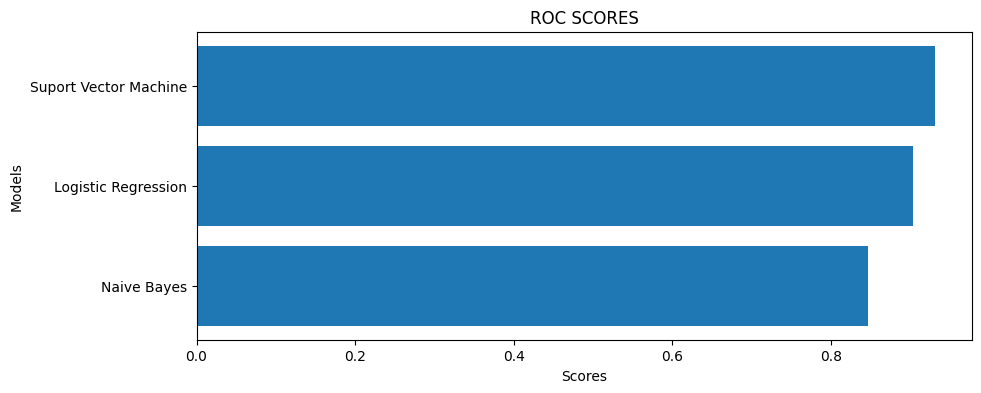

In [74]:
models = {
    'Naive Bayes': MultinomialNB,
    'Suport Vector Machine': SVC,
    'Logistic Regression': LogisticRegression
}

testing = modelling(models, X_train_tf, X_test_tf, y_train, y_test)
print('Testing with TF-IDF')
print(testing.fit_models())
testing.plot_scores()


Testing with Count Vectorizer


  0%|          | 0/3 [00:00<?, ?it/s]

Training Naive Bayes...
Training Suport Vector Machine...


100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

Training Logistic Regression...
                  models    scores
0            Naive Bayes  0.951904
2    Logistic Regression  0.932000
1  Suport Vector Machine  0.930113


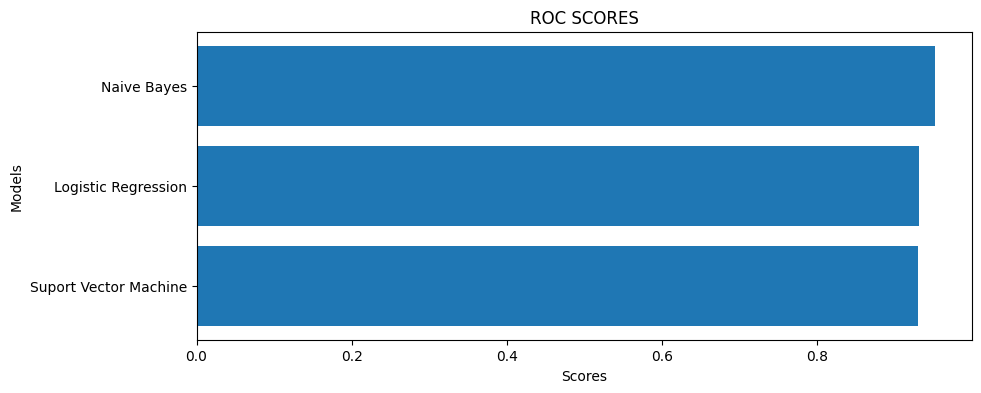

In [70]:
models2 = {
    'Naive Bayes': MultinomialNB,
    'Suport Vector Machine': SVC,
    'Logistic Regression': LogisticRegression
}

testing2 = modelling(models, X_train_cv, X_test_cv, y_train, y_test)
print("Testing with Count Vectorizer")
print(testing2.fit_models())
testing2.plot_scores()

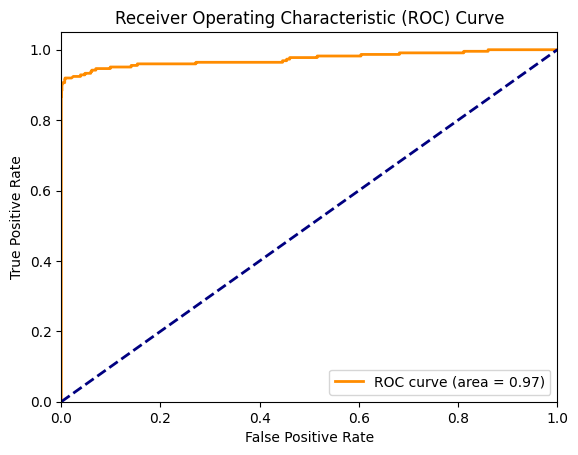

In [76]:
nb = MultinomialNB().fit(X_train_cv, y_train)
preds = nb.predict_proba(X_test_cv)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()